In [1]:
%load_ext autoreload
%autoreload 2
!RUST_BACKTRACE=1 cargo run -- ../models/quadrotor.mo -t ../templates/sympy.jinja > quadrotor_sympy.py

    Finished `dev` profile [unoptimized + debuginfo] target(s) in 0.09s
     Running `/home/jgoppert/git/rumoca_parol/target/debug/rumoca ../models/quadrotor.mo -t ../templates/sympy.jinja`


In [2]:
import quadrotor_sympy
import numpy as np
import matplotlib.pyplot as plt

model = quadrotor_sympy.Model()
model.solve()

In [3]:
model.sol_x_dot

Matrix([
[U*cos(psi)*cos(theta) + V*sin(psi)*cos(phi) + W*sin(phi)*sin(psi) + sin(phi)*sin(theta)*cos(psi) + sin(theta)*cos(phi)*cos(psi)],
[U*sin(psi)*cos(theta) + V*cos(phi)*cos(psi) + W*sin(phi)*cos(psi) + sin(phi)*sin(psi)*sin(theta) + sin(psi)*sin(theta)*cos(phi)],
[                                                                   U*sin(theta) - V*sin(phi)*cos(theta) - W*cos(phi)*cos(theta)],
[                                                                                                                              0],
[                                                                                                                              0],
[                                                                                                                              0],
[                                                                                                      -Q*W + R*V - g*sin(theta)],
[                                                                         

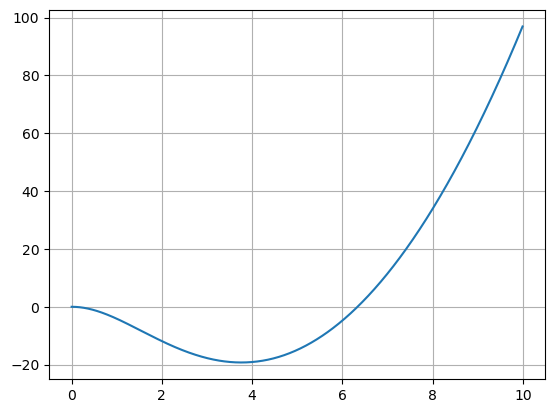

In [4]:
def f_u(t):
    omega = 2
    return np.array([omega, omega, omega, omega])

x0 = np.zeros(16)
res = model.simulate(t0=0, tf=10, dt=0.01, f_u=f_u, x0=x0)

plt.figure()
plt.plot(res['t'], res['x'][2, :].T);
#plt.plot(t, u(t).T)
plt.grid()

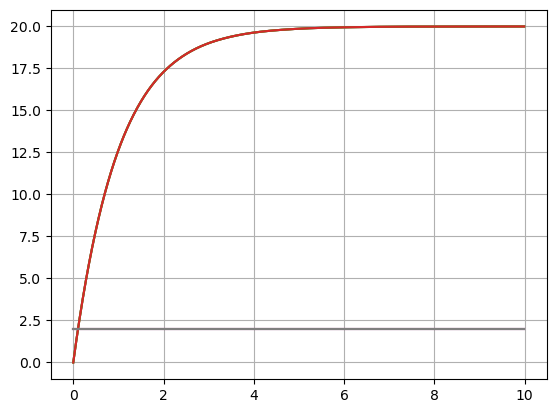

In [5]:
plt.figure()
plt.plot(res['t'], res['x'][12:16, :].T);
plt.plot(res['t'], res['u'].T)
plt.grid()

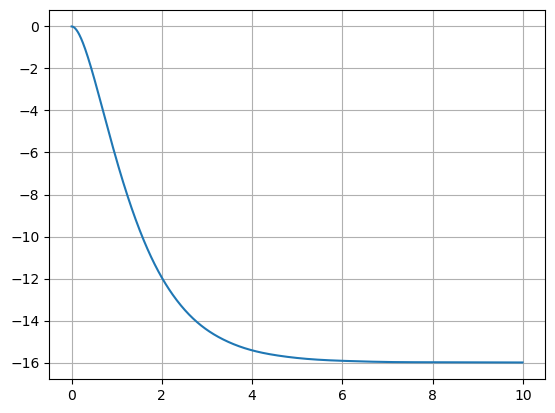

In [6]:
plt.plot(res['t'], res['y'][6, :].T);
plt.grid()

In [7]:
model.sol_x_dot

Matrix([
[U*cos(psi)*cos(theta) + V*sin(psi)*cos(phi) + W*sin(phi)*sin(psi) + sin(phi)*sin(theta)*cos(psi) + sin(theta)*cos(phi)*cos(psi)],
[U*sin(psi)*cos(theta) + V*cos(phi)*cos(psi) + W*sin(phi)*cos(psi) + sin(phi)*sin(psi)*sin(theta) + sin(psi)*sin(theta)*cos(phi)],
[                                                                   U*sin(theta) - V*sin(phi)*cos(theta) - W*cos(phi)*cos(theta)],
[                                                                                                                              0],
[                                                                                                                              0],
[                                                                                                                              0],
[                                                                                                      -Q*W + R*V - g*sin(theta)],
[                                                                         

In [8]:
model.sol_x_dot

Matrix([
[U*cos(psi)*cos(theta) + V*sin(psi)*cos(phi) + W*sin(phi)*sin(psi) + sin(phi)*sin(theta)*cos(psi) + sin(theta)*cos(phi)*cos(psi)],
[U*sin(psi)*cos(theta) + V*cos(phi)*cos(psi) + W*sin(phi)*cos(psi) + sin(phi)*sin(psi)*sin(theta) + sin(psi)*sin(theta)*cos(phi)],
[                                                                   U*sin(theta) - V*sin(phi)*cos(theta) - W*cos(phi)*cos(theta)],
[                                                                                                                              0],
[                                                                                                                              0],
[                                                                                                                              0],
[                                                                                                      -Q*W + R*V - g*sin(theta)],
[                                                                         

In [9]:
model.sol_x_dot.jacobian(model.x)

Matrix([
[0, 0, 0,  0,  0, 0, cos(psi)*cos(theta),    sin(psi)*cos(phi),    sin(phi)*sin(psi), -V*sin(phi)*sin(psi) + W*sin(psi)*cos(phi) - sin(phi)*sin(theta)*cos(psi) + sin(theta)*cos(phi)*cos(psi), -U*sin(theta)*cos(psi) + sin(phi)*cos(psi)*cos(theta) + cos(phi)*cos(psi)*cos(theta), -U*sin(psi)*cos(theta) + V*cos(phi)*cos(psi) + W*sin(phi)*cos(psi) - sin(phi)*sin(psi)*sin(theta) - sin(psi)*sin(theta)*cos(phi),                   0,                   0,                   0,                   0],
[0, 0, 0,  0,  0, 0, sin(psi)*cos(theta),    cos(phi)*cos(psi),    sin(phi)*cos(psi), -V*sin(phi)*cos(psi) + W*cos(phi)*cos(psi) - sin(phi)*sin(psi)*sin(theta) + sin(psi)*sin(theta)*cos(phi), -U*sin(psi)*sin(theta) + sin(phi)*sin(psi)*cos(theta) + sin(psi)*cos(phi)*cos(theta),  U*cos(psi)*cos(theta) - V*sin(psi)*cos(phi) - W*sin(phi)*sin(psi) + sin(phi)*sin(theta)*cos(psi) + sin(theta)*cos(phi)*cos(psi),                   0,                   0,                   0,                   0],
[0, 0

In [10]:
# linearization
A = model.sol_x_dot.jacobian(model.x).subs(model.x0).subs(model.p0).subs(model.u0)
B = model.sol_x_dot.jacobian(model.u).subs(model.x0).subs(model.p0).subs(model.u0)
C = model.sol_y.jacobian(model.x).subs(model.x0).subs(model.p0).subs(model.u0)
D = model.sol_y.jacobian(model.u).subs(model.x0).subs(model.p0).subs(model.u0)

(A, B, C, D)

(Matrix([
 [0, 0, 0, 0, 0, 0, 1, 0,  0,    0,     1, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 1,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0, -1,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0, -9.81, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0, 9.81,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0, -1,  0,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0, -1,  0,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,  0,  0, -1,  0],
 [0, 0, 0, 0, 0, 0, 0, 0,  0,    0,     0, 0,

In [ ]:
import rclpy
import rclpy.executors
from rclpy.executors import ExternalShutdownException, SingleThreadedExecutor
from rclpy.node import Node
from sensor_msgs.msg import Joy
from geometry_msgs.msg import PoseStamped, TransformStamped
from builtin_interfaces.msg import Time
from tf2_ros import TransformBroadcaster
import numpy as np  # Ensure numpy is imported

class QuadrotorNode(Node):
    def __init__(self, context):
        super().__init__(node_name='quadrotor_node', context=context)
        self.subscription = self.create_subscription(
            Joy,
            'joy',
            self.joy_callback,
            10
        )
        self.tf_broadcaster = TransformBroadcaster(self)  # Initialize the TF2 broadcaster
        self.sim_time_publisher = self.create_publisher(Time, 'sim_time', 10)  # Sim time publisher
        self.timer = self.create_timer(0.1, self.step_simulation)  # Timer to publish sim time

        self.sim_time = 0.0  # Initialize simulation time
        self.x0 = np.zeros(16)
        self.joy = [0, 0, 0, 0]

    def step_simulation(self):
        """Step the simulation."""

        # publish sim time
        self.sim_time += 0.1  # Increment simulation time by 0.1 seconds
        sim_time_msg = Time()
        sim_time_msg.sec = int(self.sim_time)
        sim_time_msg.nanosec = int((self.sim_time - int(self.sim_time)) * 1e9)
        self.sim_time_publisher.publish(sim_time_msg)
        # self.get_logger().info(f"Published sim_time: {sim_time_msg.sec}.{sim_time_msg.nanosec}")

        # integrate simulation
        omega = self.joy[1] * 20  # Example mapping from joystick input to omega
        f_u = lambda t: np.array([omega, omega, omega, omega])
        self.x0[0] = 0 # x
        self.x0[1] = 0 # y
        self.x0[2] = 0 # z
        self.x0[3] = 0 # P
        self.x0[4] = 0 # Q
        self.x0[5] = 0 # R
        self.x0[6] = 0 # U
        self.x0[7] = 0 # V
        self.x0[8] = 0 # W
        self.x0[9] = 0 # phi
        self.x0[10] = 0 # theta
        self.x0[11] = 0 # psi
        # self.get_logger().info('motors: %f %f %f %f' % tuple(self.x0[12:16]))
        res = model.simulate(t0=0, tf=0.1, dt=0.01, x0=self.x0, f_u=f_u)
        self.x0 = res['x'][:, -1]

        # Publish the transform
        transform = TransformStamped()
        transform.header.stamp = self.get_clock().now().to_msg()
        transform.header.frame_id = "map"
        transform.child_frame_id = "quadrotor"
        transform.transform.translation.x = self.x0[0]
        transform.transform.translation.y = self.x0[1]
        transform.transform.translation.z = self.x0[2]
        transform.transform.rotation.x = 0.0
        transform.transform.rotation.y = 0.0
        transform.transform.rotation.z = 0.0
        transform.transform.rotation.w = 1.0
        self.tf_broadcaster.sendTransform(transform)

    def joy_callback(self, msg):
        omega = msg.axes[1] * 20  # Example mapping from joystick input to omega
        self.joy = [msg.axes[0], msg.axes[1], msg.axes[2], msg.axes[3]]


def run(args=None):
    # Create a scoped ROS 2 context
    context = rclpy.Context()
    try:
        context.init()
        executor = SingleThreadedExecutor(context=context)
        executor.add_node(QuadrotorNode(context=context))
        executor.spin()
    except KeyboardInterrupt:
        pass
    finally:
        context.try_shutdown()
        del executor
        del context

run()

[INFO] [1743133323.542591544] [quadrotor_node]: motors: 0.000000 0.000000 0.000000 0.000000
[INFO] [1743133323.552066431] [quadrotor_node]: motors: 0.000000 0.000000 0.000000 0.000000
[INFO] [1743133323.652055760] [quadrotor_node]: motors: 0.000000 0.000000 0.000000 0.000000
[INFO] [1743133323.752045829] [quadrotor_node]: motors: 0.000000 0.000000 0.000000 0.000000
[INFO] [1743133323.852062888] [quadrotor_node]: motors: 0.000000 0.000000 0.000000 0.000000
[INFO] [1743133323.952070037] [quadrotor_node]: motors: 0.000000 0.000000 0.000000 0.000000
[INFO] [1743133324.052153526] [quadrotor_node]: motors: 0.000000 0.000000 0.000000 0.000000
[INFO] [1743133324.152073842] [quadrotor_node]: motors: 0.000000 0.000000 0.000000 0.000000
[INFO] [1743133324.252069250] [quadrotor_node]: motors: 0.000000 0.000000 0.000000 0.000000
[INFO] [1743133324.352060608] [quadrotor_node]: motors: 0.000000 0.000000 0.000000 0.000000
[INFO] [1743133324.452069645] [quadrotor_node]: motors: 0.000000 0.000000 0.0000